Date: 3/27/21
### Purpose
- Compare PnL: model-driven port vs. null portfolio

### Notes
- changes needed for model prep because new parquet raw file (added fields and refinedfeatures())

In [1]:
#Installing imblearn
#!pip install -U imbalanced-learn

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
# pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 50)

In [3]:
%%time
df = pd.read_parquet('../data/approved2.parquet', engine='fastparquet')

Wall time: 13.6 s


In [4]:
df.sample(5)

,addr_state,annual_inc,application_type,disbursement_method,dti,earliest_cr_line,emp_length,emp_title,fico_range_high,fico_range_low,grade,home_ownership,initial_list_status,inq_last_6mths,installment,int_rate,issue_d,last_pymnt_d,loan_amnt,loan_status,open_acc,pub_rec,pub_rec_bankruptcies,purpose,sub_grade,term,total_pymnt,verification_status,zip_code,days_since_first_credit,fico_score_average
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
67258501,NY,25000.0,Individual,Cash,20.69,2002-10-01,10,Manager,704.0,700.0,C,RENT,w,0.0,401.97,12.59,2015-12-01,2016-11-01,12000.0,1,7.0,0.0,0.0,small_business,12,36,13205.650000,Source Verified,115xx,4809,702.0
11896143,FL,26000.0,Individual,Cash,21.05,2003-09-01,3,Professor of Physics,699.0,695.0,B,RENT,f,0.0,314.67,11.99,2014-02-01,2014-08-01,9475.0,1,26.0,0.0,0.0,debt_consolidation,8,36,10009.611337,Not Verified,347xx,3806,697.0
62012358,PA,51000.0,Individual,Cash,5.84,2007-01-01,10,shipping manager,669.0,665.0,B,RENT,w,0.0,318.79,9.17,2015-10-01,2018-10-01,10000.0,1,6.0,0.0,0.0,credit_card,7,36,11471.313647,Source Verified,156xx,3195,667.0
59581257,MN,40000.0,Individual,Cash,39.90,1992-12-01,9,Project Coordinator,774.0,770.0,B,MORTGAGE,f,1.0,439.88,8.18,2015-09-01,2018-09-01,14000.0,1,12.0,0.0,0.0,credit_card,6,36,15829.018071,Verified,561xx,8309,772.0
141288254,MI,85000.0,Individual,DirectPay,18.41,2007-01-01,10,TREASURY SPECIALIST,719.0,715.0,C,MORTGAGE,w,1.0,1204.23,14.47,2018-10-01,2019-01-01,35000.0,1,17.0,0.0,0.0,debt_consolidation,12,36,36563.638695,Source Verified,492xx,4291,717.0


inq_last_6mths        1
zip_code              1
last_pymnt_d       2087
emp_title         83045
dtype: int64

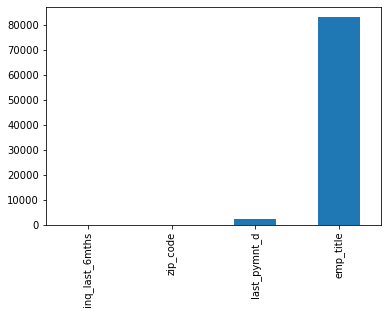

In [5]:
missing = df.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()
missing

### Feature Engineering

In [6]:
df.drop(df[df['last_pymnt_d'].isna()].index, inplace=True)
df.drop(df[df['inq_last_6mths'].isna()].index, inplace=True)

df['duration']=df['last_pymnt_d']-df['issue_d']
df['duration'] = (df['duration'] / np.timedelta64(1,'D')).astype(int)

df['PnL']=df['total_pymnt']-df['loan_amnt']

# create df_full to get back PnL for model driven portfolio later
df_full = df.copy(deep=True)

### Convert Ordinals

In [7]:
# # sub_grade
# df.sub_grade.replace({'A1':1, 'A2':2, 'A3':3, 'A4':4, 'A5':5, 'B1':6, 'B2':7, 
#                       'B3':8, 'B4':9, 'B5':10, 'C1':11, 'C2':12, 'C3':13, 'C4':14, 
#                       'C5':15, 'D1':16, 'D2':17, 'D3':18, 'D4':19, 'D5':20, 'E1':21, 
#                       'E2':22, 'E3':23, 'E4':24, 'E5':25}, inplace=True)

# disbursement_method
df.disbursement_method.replace({'Cash':0,'DirectPay':1},inplace=True)

# verification_status
df.verification_status.replace({'Source Verified':'Verified'},inplace=True)
df.verification_status.replace({'Not Verified':0,'Verified':1}, inplace=True)

# initial_list_status
df.initial_list_status.replace({'w':0,'f':1}, inplace=True)

# application_type
df.application_type.replace({'Individual':0,'Joint App':1}, inplace=True)

### Dummification

In [8]:
dummies=['purpose','addr_state','home_ownership']

for d in dummies:
    temp = pd.get_dummies(df[d], prefix=d, prefix_sep='__')
    temp = temp.drop(d+'__'+str(df[d].mode()[0]), axis=1)
    #drop the most common one (mode), making it the base case
    df = pd.concat([df.drop(d, axis=1),temp], axis=1)
    #merge back with main df

### Filter for years

In [9]:
df= df.loc[df['issue_d'].dt.year.between(2007,2015)]

In [10]:
df.issue_d.dt.year.count()

799772

### Drop Columns

In [11]:
df.drop(['emp_title','zip_code','grade','issue_d','earliest_cr_line','fico_range_high',
         'fico_range_low','installment'],axis=1, inplace=True)

In [12]:
df.drop(['duration','last_pymnt_d','PnL','total_pymnt'], axis=1, inplace=True)

### Drop emp_length==-1

In [13]:
df.drop(df[df['emp_length']==-1].index, inplace=True)

In [14]:
df = df.dropna(how='all')

### Drop the 60month product

In [15]:
df = df.loc[df['term']==36]
df.drop('term', axis=1, inplace=True)

# Modelling

### create target and features

In [16]:
target = df['loan_status']

In [17]:
target.value_counts()

1    500426
0     76601
Name: loan_status, dtype: int64

In [18]:
features = df.drop(['loan_status'], axis=1)

### note the reduced train_size of .10

In [19]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, KFold

Xtrain, Xtest, ytrain, ytest = train_test_split(features, target, train_size=.10 )
logr = LogisticRegression()

### gridsearch

In [20]:
Cs = [0.0001,0.001,0.01,1,10,100,1000,10000]
params = [{'C':Cs, 'penalty':['l1','l2']}]
grid_logr = GridSearchCV(estimator=logr, param_grid=params, cv=3)

In [21]:
%%time
grid_logr.fit(Xtest, ytest)

Wall time: 2min 5s


GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid=[{'C': [0.0001, 0.001, 0.01, 1, 10, 100, 1000, 10000],
                          'penalty': ['l1', 'l2']}])

In [22]:
print(grid_logr.best_params_)
print(grid_logr.best_score_)

{'C': 0.0001, 'penalty': 'l2'}
0.8674279112262337


In [23]:
best_model = grid_logr.best_estimator_
best_model.score(Xtest,ytest)

0.8674202089250469

In [24]:
coefs = pd.DataFrame(abs(best_model.coef_).T, index=features.columns)

In [25]:
coefs.sort_values(0, ascending=False).head(10)

,0
sub_grade,0.047557
int_rate,0.032430
dti,0.030583
open_acc,0.010102
fico_score_average,0.004721
inq_last_6mths,0.003473
home_ownership__RENT,0.001226
verification_status,0.001146
pub_rec,0.000791
purpose__credit_card,0.000781


### Confusion Matrix

In [26]:
from sklearn.metrics import confusion_matrix

In [27]:
cmat = confusion_matrix(ytest,best_model.predict(Xtest))

#Label the confusion matrix
pd.DataFrame(cmat, columns = [f'Pred_{label}' for label in best_model.classes_],
             index = [f'True_{label}' for label in best_model.classes_])


,Pred_0,Pred_1
True_0,2,68845
True_1,7,450471


### Best model is one that strikes good balance of a high "pred_1 precision" and a high "loan approval rate"

In [28]:
cmat=cmat
print(f'loan approval rate: {sum(cmat[:,1])/sum(sum(cmat)):.2f}')
print(f'precision pred_1: {cmat[1][1]/sum(cmat[:,1]):.2f}')
print(f'recall pred_1: {cmat[1][1]/sum(cmat[1,:]):.2f}')

loan approval rate: 1.00
precision pred_1: 0.87
recall pred_1: 1.00


In [29]:
from sklearn.metrics import classification_report
print(classification_report(ytest, best_model.predict(Xtest)))

              precision    recall  f1-score   support

           0       0.22      0.00      0.00     68847
           1       0.87      1.00      0.93    450478

    accuracy                           0.87    519325
   macro avg       0.54      0.50      0.46    519325
weighted avg       0.78      0.87      0.81    519325



### Merge test results back into the df to investigate the 'fully paid fails'

In [30]:
model_results = pd.Series(best_model.predict(Xtest), index = Xtest.index, name="loan_status_predict")

In [31]:
df2 = pd.concat([Xtest, ytest, model_results], axis=1 )

In [32]:
fails = df2.loc[(df2['loan_status'] == 0) & (df2['loan_status_predict'] == 1)]
fails

,annual_inc,application_type,disbursement_method,dti,emp_length,initial_list_status,inq_last_6mths,int_rate,loan_amnt,open_acc,pub_rec,pub_rec_bankruptcies,sub_grade,verification_status,days_since_first_credit,fico_score_average,purpose__car,purpose__credit_card,purpose__educational,purpose__home_improvement,purpose__house,purpose__major_purchase,purpose__medical,purpose__moving,purpose__other,...,addr_state__NV,addr_state__NY,addr_state__OH,addr_state__OK,addr_state__OR,addr_state__PA,addr_state__RI,addr_state__SC,addr_state__SD,addr_state__TN,addr_state__TX,addr_state__UT,addr_state__VA,addr_state__VT,addr_state__WA,addr_state__WI,addr_state__WV,addr_state__WY,home_ownership__ANY,home_ownership__NONE,home_ownership__OTHER,home_ownership__OWN,home_ownership__RENT,loan_status,loan_status_predict
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2090707,65000.0,0,0,16.45,3,0,0.0,14.33,9750.0,9.0,0.0,0.0,11,0,2315,672.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
6717890,100000.0,0,0,21.80,4,1,2.0,18.85,4000.0,9.0,0.0,0.0,18,1,4930,702.0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
28643840,75000.0,0,0,12.19,10,0,0.0,10.99,13000.0,13.0,0.0,0.0,8,0,4840,697.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
44138131,21500.0,0,0,10.61,10,1,0.0,11.53,7000.0,6.0,0.0,0.0,10,1,2981,667.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
6976030,68567.0,0,0,18.81,2,0,1.0,15.22,6975.0,9.0,0.0,0.0,13,0,3500,702.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54187456,61000.0,0,0,36.02,10,1,0.0,10.99,6000.0,11.0,0.0,0.0,9,0,6969,712.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
36018237,32000.0,0,0,18.00,10,1,0.0,11.99,16000.0,9.0,1.0,0.0,10,1,2891,702.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1
37897153,43500.0,0,0,29.35,10,1,4.0,14.99,4000.0,12.0,1.0,1.0,15,1,5054,662.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1


### PnL analysis

In [33]:
model_port = df2.loc[df2['loan_status_predict'] == 1]

In [34]:
PnL = df_full['PnL']

In [35]:
model_port = model_port.merge(PnL, how='inner',left_index=True,right_index=True)

In [36]:
print(f'Total investment for Model Portfolio: {model_port.loan_amnt.sum():.0f}')
print(f'Total PnL for Model Portfolio: {model_port.PnL.sum():.0f}')
print(f'Return for Model Portfolio: {(model_port.PnL.sum()/model_port.loan_amnt.sum())*100:.2f}%')

Total investment for Model Portfolio: 6574852625
Total PnL for Model Portfolio: 552672949
Return for Model Portfolio: 8.41%


In [37]:
null_port = df2.merge(PnL, how='inner',left_index=True,right_index=True)

In [38]:
print(f'Total investment for Null Portfolio: {null_port.loan_amnt.sum():.0f}')
print(f'Total PnL for Null Portfolio: {null_port.PnL.sum():.0f}')
print(f'Return for Null Portfolio: {(null_port.PnL.sum()/null_port.loan_amnt.sum())*100:.2f}%')

Total investment for Null Portfolio: 6574956025
Total PnL for Null Portfolio: 552676609
Return for Null Portfolio: 8.41%


In [39]:
null_port
null_port.to_csv('null_port.csv')

### Research the model fails

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns
sns.countplot(x=fails['sub_grade'],ax=ax1)
sns.countplot(x=Xtest['sub_grade'],ax=ax2)

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
sns.histplot(data=fails, x="dti", ax=ax1)
sns.histplot(data=Xtest, x="dti", ax=ax2)
plt.xlim(0, 40)
# plt.show()

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
sns.histplot(data=fails, x="int_rate", ax=ax1)
sns.histplot(data=Xtest, x="int_rate", ax=ax2)

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
sns.histplot(data=fails, x="emp_length", ax=ax1)
sns.histplot(data=Xtest, x="emp_length", ax=ax2)

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
sns.histplot(data=fails, x="fico_score_average", ax=ax1)
sns.histplot(data=Xtest, x="fico_score_average", ax=ax2)

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
sns.histplot(data=fails, x="open_acc", ax=ax1)
sns.histplot(data=Xtest, x="open_acc", ax=ax2)

### change the threshold to improve the pred_1 precision

In [ ]:
probs_positive_class = best_model.predict_proba(Xtest)[:, 1]
prediction = probs_positive_class > .6

In [ ]:
cmat2 = confusion_matrix(ytest, prediction, labels=[0, 1])
pd.DataFrame(cmat2, columns = [f'Pred_{label}' for label in best_model.classes_],
             index = [f'True_{label}' for label in best_model.classes_])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(ytest, prediction))

In [ ]:
cmat=cmat2
print(f'loan approval rate: {sum(cmat[:,1])/sum(sum(cmat)):.2f}')
print(f'precision pred_1: {cmat[1][1]/sum(cmat[:,1]):.2f}')
print(f'recall pred_1: {cmat[1][1]/sum(cmat[1,:]):.2f}')

### Loop to check thresholds

In [ ]:
thresholds = np.linspace(0.5,1,19)

for i in thresholds:
    probs_positive_class = best_model.predict_proba(Xtest)[:, 1]
    prediction = probs_positive_class > i
    cmat = confusion_matrix(ytest, prediction, labels=[0, 1])
    print(f'threshold:{i:.2f}')
    print(f'loan approval rate: {sum(cmat[:,1])/sum(sum(cmat)):.2f}')
    print(f'precision pred_1: {cmat[1][1]/sum(cmat[:,1]):.2f}')
    print(f'recall pred_1: {cmat[1][1]/sum(cmat[1,:]):.2f}')
    print("-"*50)

## ROC Curve

In [ ]:
from sklearn.metrics import roc_curve

In [ ]:
# predict probabilities
yhat = logr.predict_proba(Xtest)

In [ ]:
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]

In [ ]:
# calculate roc curves
fpr, tpr, thresholds = roc_curve(ytest, yhat)

In [ ]:
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [ ]:
# calculate roc curves
fpr, tpr, thresholds = roc_curve(ytest, prediction)

In [ ]:
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

### SGD classifier

### Save model in pickle

In [ ]:
filename = 'grid_logr_model.sav'
pickle.dump(grid_logr, open(filename, 'wb'))

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(Xtest, ytest)
print(result)